In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed

In [45]:
warnings.filterwarnings("ignore")

In [277]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2014-12-29',end='2021-12-31')
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0
mean,92.150689,93.008318,91.302414,92.150635,1.513972e+07,0.010561,0.0
std,32.584003,32.882706,32.299042,32.572711,6.646317e+06,0.087102,0.0
min,44.681974,45.383564,41.570076,44.559067,3.324300e+06,0.000000,0.0
25%,57.656303,57.925802,57.416999,57.690491,1.088610e+07,0.000000,0.0
50%,93.184584,94.177574,92.318731,93.221817,1.354240e+07,0.000000,0.0
75%,104.620881,105.376327,103.911238,104.580650,1.725090e+07,0.000000,0.0
max,170.417716,170.664397,168.276520,169.500061,5.619230e+07,1.000000,0.0


In [278]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Rendimenti
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0,1764.000000
mean,92.150689,93.008318,91.302414,92.150635,1.513972e+07,0.010561,0.0,0.060192
std,32.584003,32.882706,32.299042,32.572711,6.646317e+06,0.087102,0.0,1.613196
min,44.681974,45.383564,41.570076,44.559067,3.324300e+06,0.000000,0.0,-10.086377
25%,57.656303,57.925802,57.416999,57.690491,1.088610e+07,0.000000,0.0,-0.622680
50%,93.184584,94.177574,92.318731,93.221817,1.354240e+07,0.000000,0.0,0.070237
75%,104.620881,105.376327,103.911238,104.580650,1.725090e+07,0.000000,0.0,0.763077
max,170.417716,170.664397,168.276520,169.500061,5.619230e+07,1.000000,0.0,10.493415


ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura e dei rendimenti del titolo, sia volta a studiare la forza della correlazione serialedi ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

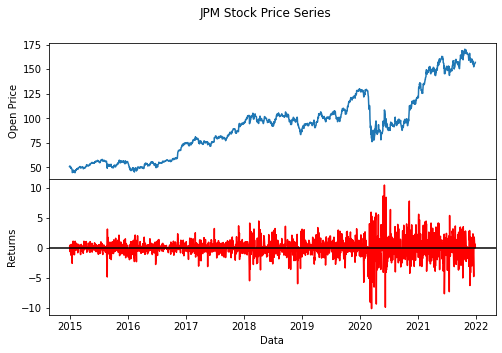

In [279]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'], color ="red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()
plt.show()
# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\serie.pdf", bbox_inches='tight', format="pdf")


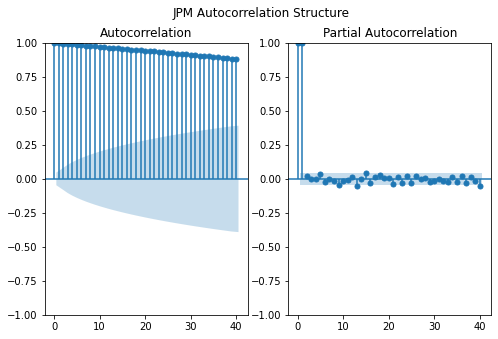

In [280]:
# ACF E PACF della serie dei prezzi
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\cor.pdf", bbox_inches='tight', format="pdf")

In [281]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -0.431580
P-Value                   0.904691
# Lags Used               5.000000
# Observations Used    1759.000000
dtype: float64


MODELLAZIONE ARIMA



In [282]:
# creazione del train e del test set
size = int(len(JPM) * 0.839)
print(size)
dataset_train = JPM[0:size]
training_set = dataset_train.iloc[:, 0:1].values
dataset_test = JPM[size:]
test_set = dataset_test.iloc[:,0:1].values
print(training_set.shape)
print(test_set.shape)

1480
(1480, 1)
(285, 1)


In [289]:
# con finestra di 5 giorni
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(0, test_set.shape[0],5):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=5)
    yhat = output
    predictions.append(yhat)
    obs = test_set[t-5:t]
    history.append(obs)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [161]:
# con finestra di un giorno
#history = [x for x in training_set]
#predictions = list()
# walk-forward validation
#for t in range(len(test_set)):
#    model = ARIMA(history, order=(1,1,0))
#    model_fit = model.fit()
#    output = model_fit.forecast()
#    yhat = output[0]
#    predictions.append(yhat)
#    obs = test_set[t]
#    history.append(obs)

In [284]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1536
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3034.599
Date:                Tue, 28 Jun 2022   AIC                           6073.197
Time:                        15:09:53   BIC                           6083.870
Sample:                             0   HQIC                          6077.169
                               - 1536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0174      0.014     -1.264      0.206      -0.044       0.010
sigma2         3.0526      0.042     71.872      0.000       2.969       3.136
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [285]:
print(test_set.shape)
print(np.array(predictions).shape)
predictions = np.array(predictions)
predictions = predictions.reshape(-1,1)

(285, 1)
(57, 5)


In [286]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)

Mean Squared Error:	 31.16719126209591


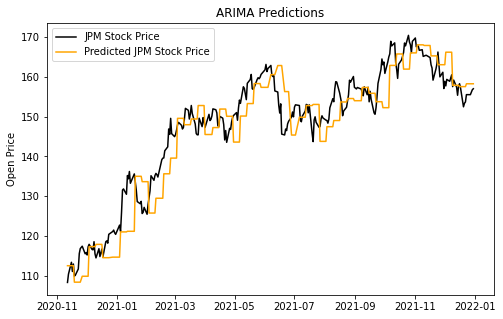

In [287]:
predictions = pd.DataFrame(predictions)
predictions= predictions.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_arima.pdf", bbox_inches='tight', format="pdf")

In [37]:
# ARIMA(2,1,0)
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(0, test_set.shape[0],5):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(5)
    yhat = output
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [38]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3344.142
Date:                Mon, 27 Jun 2022   AIC                           6694.284
Time:                        22:33:30   BIC                           6710.708
Sample:                             0   HQIC                          6700.353
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0404      0.014     -2.852      0.004      -0.068      -0.013
ar.L2          0.0174      0.014      1.227      0.220      -0.010       0.045
sigma2         2.6008      0.042     61.542      0.0

CONVOLUTIONAL NEURAL NETWORK

In [290]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = mc.fit_transform(training_set)
print(training_set_scaled.shape)

(1480, 1)


In [291]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(295, 5, 1)
(295, 5, 1)
(295, 5, 1)


In [ ]:
# Costruzione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

In [299]:
# rete CNN base
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_118 (Conv1D)         (None, 4, 64)             192       
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_87 (Flatten)        (None, 128)               0         
                                                                 
 dense_177 (Dense)           (None, 32)                4128      
                                                                 
 dense_178 (Dense)           (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
___________________________________________________

In [300]:

batch_size = 4
epochs = 20
set_seed(190)
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
74/74 [==============================] - 1s 2ms/step - loss: 0.1213 - MSE: 0.1213
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 0.1037 - MSE: 0.1037
Epoch 3/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0608 - MSE: 0.0608
Epoch 4/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0019 - MSE: 0.0019
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013 
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014   
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014 
Epoch 10/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 11/20
74/74 [==============================] - 0s 2ms/step

In [302]:
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price= predicted_stock_price.set_index(dataset_test.index)

(285, 1)


Mean Squared Error:	 15.89081029422853


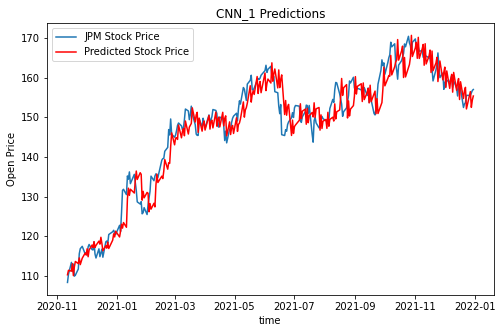

In [303]:
# MSE e rappresentazione delle previsioni
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN_1 Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1.pdf", bbox_inches='tight', format="pdf")

In [304]:
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
set_seed(190)
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[['MSE']])
model_5_CNN.fit(X_train, y_train, batch_size=4, epochs=20)

Epoch 1/20
74/74 [==============================] - 1s 2ms/step - loss: 0.0204 - MSE: 0.0204
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0020 - MSE: 0.0020  
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0021 - MSE: 0.0021
Epoch 6/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0039 - MSE: 0.0039
Epoch 7/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0025 - MSE: 0.0025
Epoch 8/20
74/74 [==============================] - 0s 5ms/step - loss: 0.0018 - MSE: 0.0018
Epoch 9/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0023 - MSE: 0.0023
Epoch 10/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0020 - MSE: 0.0020
Epoch 11/20
74/74 [==============================] - 0s 3ms/step - 

Mean Squared Error:	 2217.3236465663667


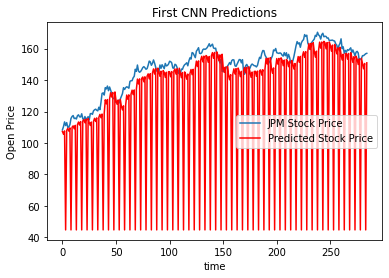

In [305]:
# MSE ed previsionipredicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [306]:
# MODIFICO IL LEARING RATE A 0.02
model_5_CNN_2 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
set_seed(190)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_5_CNN_2.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[['MSE']])
model_5_CNN_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
74/74 [==============================] - 1s 2ms/step - loss: 0.0765 - MSE: 0.0765
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0534 - MSE: 0.0534
Epoch 3/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0533 - MSE: 0.0533
Epoch 4/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0537 - MSE: 0.0537
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0538 - MSE: 0.0538
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0558 - MSE: 0.0558
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0541 - MSE: 0.0541
Epoch 8/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0530 - MSE: 0.0530
Epoch 9/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0532 - MSE: 0.0532
Epoch 10/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0530 - MSE: 0.0530
Epoch 11/20
74/74 [==============================] - 0s 3ms/step - lo

Mean Squared Error:	 2217.3235416466514


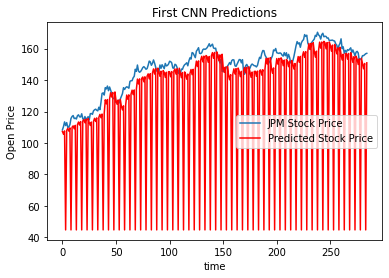

In [307]:
# MSE ed previsionipredicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = model_5_CNN_2.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [310]:
# AUMENTO IL BATCH_SIZE A 10
set_seed(12)
model_5_CNN_3 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_3.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_3.fit(X_train,y_train,epochs=20,batch_size=10)

Epoch 1/20
30/30 [==============================] - 1s 4ms/step - loss: 0.1151 - MSE: 0.1151
Epoch 2/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - MSE: 0.0143
Epoch 3/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0045 - MSE: 0.0045
Epoch 4/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0018 - MSE: 0.0018
Epoch 5/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 6/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 7/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014   
Epoch 8/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0013 - MSE: 0.0013   
Epoch 10/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 11/20
30/30 [==============================] - 0s 3ms/

Mean Squared Error:	 28.597082714543273


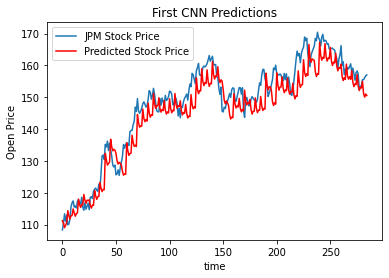

In [311]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_3.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [312]:
# AUMENTO IL NUMERO DI EPOCHE A 60
set_seed(10)
model_5_CNN_4 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_4.fit(X_train,y_train,epochs=60,batch_size=4)

Epoch 1/60
74/74 [==============================] - 1s 3ms/step - loss: 0.0887 - MSE: 0.0887
Epoch 2/60
74/74 [==============================] - 0s 3ms/step - loss: 0.0339 - MSE: 0.0339
Epoch 3/60
74/74 [==============================] - 0s 3ms/step - loss: 0.0023 - MSE: 0.0023
Epoch 4/60
74/74 [==============================] - 0s 3ms/step - loss: 0.0015 - MSE: 0.0015
Epoch 5/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0016 - MSE: 0.0016 
Epoch 6/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0016 - MSE: 0.0016
Epoch 7/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0017 - MSE: 0.0017 
Epoch 8/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0018 - MSE: 0.0018
Epoch 9/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0015 - MSE: 0.0015
Epoch 10/60
74/74 [==============================] - 0s 2ms/step - loss: 0.0016 - MSE: 0.0016  
Epoch 11/60
74/74 [==============================] - 0s 3ms/step 

Mean Squared Error:	 41.48685507301197


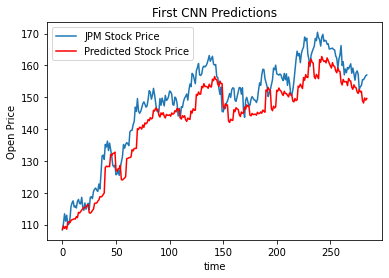

In [313]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_4.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [314]:
# AGGIUNGO UN LIVELLO CONVOLUTIVO IN PIù
set_seed(10)
model_5_CNN_5 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.Conv1D(40, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(30, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_5_CNN_5.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_124 (Conv1D)         (None, 3, 64)             256       
                                                                 
 conv1d_125 (Conv1D)         (None, 2, 40)             5160      
                                                                 
 max_pooling1d_93 (MaxPoolin  (None, 1, 40)            0         
 g1D)                                                            
                                                                 
 flatten_93 (Flatten)        (None, 40)                0         
                                                                 
 dense_189 (Dense)           (None, 30)                1230      
                                                                 
 dense_190 (Dense)           (None, 5)                 155       
                                                     

In [315]:
set_seed(10)
model_5_CNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_5.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
74/74 [==============================] - 1s 3ms/step - loss: 0.0710 - MSE: 0.0710
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0019 - MSE: 0.0019
Epoch 3/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0016 - MSE: 0.0016
Epoch 4/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 5/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014 
Epoch 6/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0016 - MSE: 0.0016
Epoch 7/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0016 - MSE: 0.0016
Epoch 8/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0016 - MSE: 0.0016
Epoch 9/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014 
Epoch 10/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014  
Epoch 11/20
74/74 [==============================] - 0s 3ms/step 

Mean Squared Error:	 22.41552379861258


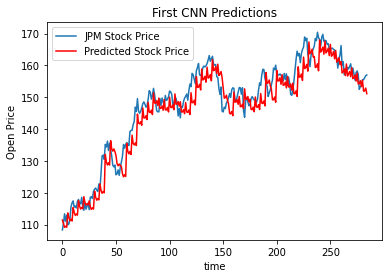

In [316]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_5.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(real_stock_price, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [317]:
# USO COME FUNZIONE DI ATTIVAZIONE DEL LIVELLO DI OUTPUT LA FUNZIONE LINEARE
model_5_CNN_6 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "linear")
    ]
)
model_5_CNN_6.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_126 (Conv1D)         (None, 4, 64)             192       
                                                                 
 max_pooling1d_94 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_94 (Flatten)        (None, 128)               0         
                                                                 
 dense_191 (Dense)           (None, 32)                4128      
                                                                 
 dense_192 (Dense)           (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
___________________________________________________

In [318]:
set_seed(10)
model_5_CNN_6.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN_6.fit(X_train,y_train,epochs=20,batch_size=4)

Epoch 1/20
74/74 [==============================] - 1s 2ms/step - loss: 0.0564 - MSE: 0.0564
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0021 - MSE: 0.0021
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 5/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014   
Epoch 6/20
74/74 [==============================] - 0s 4ms/step - loss: 0.0014 - MSE: 0.0014
Epoch 7/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0015 - MSE: 0.0015 
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0015 - MSE: 0.0015
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0013 - MSE: 0.0013 
Epoch 10/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0014 - MSE: 0.0014 
Epoch 11/20
74/74 [==============================] - 0s 3ms/ste

In [355]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_6.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

ValueError: in user code:

    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_65" is incompatible with the layer: expected shape=(None, 5, 1), found shape=(None, 10, 1)


In [320]:
# WALK-FORWARD VALIDATION CON FINESTRA TEMPORALE DI 10 GIORNI
# training set
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled_10.shape[0], temp):
  X_train.append(training_set_scaled_10[i-temp:i+temp, 0])
  y_train.append(training_set_scaled_10[i:i+temp, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(293, 10)
(293, 10, 1)
(293, 5)


In [ ]:
# creazione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp-temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i+temp, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

In [321]:
model_10_CNN = keras.Sequential(
    [
     keras.Input(shape=(10,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(45, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model_10_CNN.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_127 (Conv1D)         (None, 8, 64)             256       
                                                                 
 max_pooling1d_95 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_95 (Flatten)        (None, 256)               0         
                                                                 
 dense_193 (Dense)           (None, 45)                11565     
                                                                 
 dense_194 (Dense)           (None, 5)                 230       
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________

In [322]:
batch_size = 4
epochs = 20
set_seed(10)
model_10_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_10_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
74/74 [==============================] - 1s 3ms/step - loss: 0.0672 - MSE: 0.0672
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0516 - MSE: 0.0516
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0516 - MSE: 0.0516
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0516 - MSE: 0.0516
Epoch 5/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0516 - MSE: 0.0516
Epoch 6/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0515 - MSE: 0.0515
Epoch 7/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0516 - MSE: 0.0516
Epoch 8/20
74/74 [==============================] - 0s 3ms/step - loss: 0.0515 - MSE: 0.0515
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0515 - MSE: 0.0515
Epoch 10/20
74/74 [==============================] - 0s 2ms/step - loss: 0.0515 - MSE: 0.0515
Epoch 11/20
74/74 [==============================] - 0s 3ms/step - lo

In [353]:
predicted_stock_price = model_10_CNN(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
print(predicted_stock_price.shape)
print(real_stock_price.shape)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)


(290, 1)
(285, 1)


Mean Squared Error:	 678.1534149862664


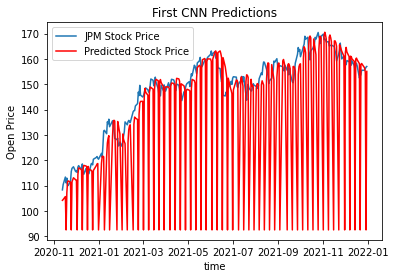

In [354]:
# non eseguire
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price[0:290], label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 

RETE RICORRENTE

In [326]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True, activation="relu")(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN = keras.Model(encoder_inputs, output)
model_RNN.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_97 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_128 (Conv1D)         (None, 8, 64)             256       
                                                                 
 conv1d_129 (Conv1D)         (None, 6, 64)             12352     
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_96 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_29 (RepeatVec  (None, 5, 192)           0         
 tor)                                                     

In [327]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
19/19 [==============================] - 2s 11ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 2/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 3/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 4/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 5/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 6/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 7/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 8/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 9/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 10/20
19/19 [==============================] - 0s 12ms/step - loss: 0.2550 - MSE: 0.2550
Epoch 11/20
19/19 [==============================] - 0s 12m

Mean Squared Error:	 3298.443136173838


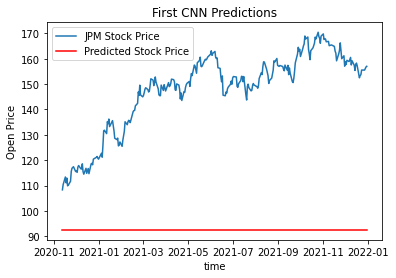

In [351]:
# MSE ed previsioni
predicted_stock_price = model_RNN.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(58,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [ ]:
# cambio della funzione di attivazione nel layer LSTM e del primo layer denso

In [348]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN_2 = keras.Model(encoder_inputs, output)
model_RNN_2.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_101 (InputLayer)      [(None, 10, 1)]           0         
                                                                 
 conv1d_136 (Conv1D)         (None, 8, 64)             256       
                                                                 
 conv1d_137 (Conv1D)         (None, 6, 64)             12352     
                                                                 
 max_pooling1d_100 (MaxPooli  (None, 3, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_100 (Flatten)       (None, 192)               0         
                                                                 
 repeat_vector_33 (RepeatVec  (None, 5, 192)           0         
 tor)                                                     

In [349]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
19/19 [==============================] - 3s 13ms/step - loss: 0.0740 - MSE: 0.0740
Epoch 2/20
19/19 [==============================] - 0s 12ms/step - loss: 0.0118 - MSE: 0.0118
Epoch 3/20
19/19 [==============================] - 0s 12ms/step - loss: 0.0030 - MSE: 0.0030
Epoch 4/20
19/19 [==============================] - 0s 12ms/step - loss: 0.0013 - MSE: 0.0013
Epoch 5/20
19/19 [==============================] - 0s 12ms/step - loss: 7.1138e-04 - MSE: 7.1138e-04
Epoch 6/20
19/19 [==============================] - 0s 11ms/step - loss: 5.6786e-04 - MSE: 5.6786e-04
Epoch 7/20
19/19 [==============================] - 0s 11ms/step - loss: 5.5723e-04 - MSE: 5.5723e-04
Epoch 8/20
19/19 [==============================] - 0s 11ms/step - loss: 4.7438e-04 - MSE: 4.7438e-04
Epoch 9/20
19/19 [==============================] - 0s 11ms/step - loss: 4.6204e-04 - MSE: 4.6204e-04
Epoch 10/20
19/19 [==============================] - 0s 12ms/step - loss: 4.4479e-04 - MSE: 4.4479e-04
Epoch 11/20

Mean Squared Error:	 18.564707572143128


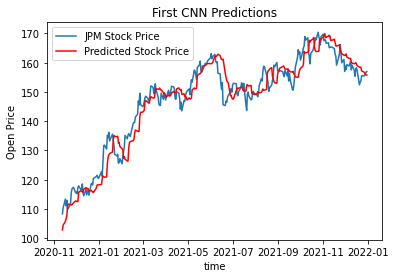

In [350]:
# MSE ed previsioni
predicted_stock_price = model_RNN_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(58,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [333]:
# provo a modificare il learning rate a 0.02
model_RNN_3 = keras.Model(encoder_inputs, output)
model_RNN_3.summary()

batch_size = 16
epochs = 20
set_seed(456984)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_RNN_3.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[['MSE']])
model_RNN_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_98 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_130 (Conv1D)         (None, 8, 64)             256       
                                                                 
 conv1d_131 (Conv1D)         (None, 6, 64)             12352     
                                                                 
 max_pooling1d_97 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_97 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_30 (RepeatVec  (None, 5, 192)           0         
 tor)                                                     

Mean Squared Error:	 3298.443136173838


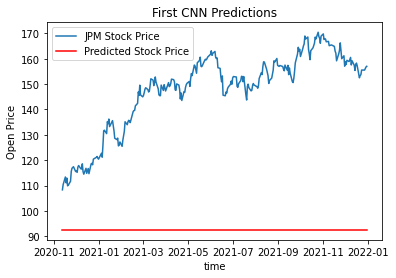

In [346]:
predicted_stock_price = model_RNN_3.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(58,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [335]:
# diminuisco l'ampiezza del kernel nei livelli convolutivi
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 2, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_RNN_4 = keras.Model(encoder_inputs, output)
model_RNN_4.summary()


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_99 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_132 (Conv1D)         (None, 9, 64)             192       
                                                                 
 conv1d_133 (Conv1D)         (None, 8, 64)             8256      
                                                                 
 max_pooling1d_98 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_98 (Flatten)        (None, 256)               0         
                                                                 
 repeat_vector_31 (RepeatVec  (None, 5, 256)           0         
 tor)                                                     

In [336]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
19/19 [==============================] - 4s 13ms/step - loss: 0.0683 - MSE: 0.0683
Epoch 2/20
19/19 [==============================] - 0s 13ms/step - loss: 0.0096 - MSE: 0.0096
Epoch 3/20
19/19 [==============================] - 0s 13ms/step - loss: 0.0026 - MSE: 0.0026
Epoch 4/20
19/19 [==============================] - 0s 13ms/step - loss: 0.0010 - MSE: 0.0010
Epoch 5/20
19/19 [==============================] - 0s 12ms/step - loss: 5.4005e-04 - MSE: 5.4005e-04
Epoch 6/20
19/19 [==============================] - 0s 12ms/step - loss: 4.6180e-04 - MSE: 4.6180e-04
Epoch 7/20
19/19 [==============================] - 0s 12ms/step - loss: 4.4221e-04 - MSE: 4.4221e-04
Epoch 8/20
19/19 [==============================] - 0s 13ms/step - loss: 3.9116e-04 - MSE: 3.9116e-04
Epoch 9/20
19/19 [==============================] - 0s 13ms/step - loss: 3.7099e-04 - MSE: 3.7099e-04
Epoch 10/20
19/19 [==============================] - 0s 11ms/step - loss: 3.5805e-04 - MSE: 3.5805e-04
Epoch 11/20

Mean Squared Error:	 16.870416094720767


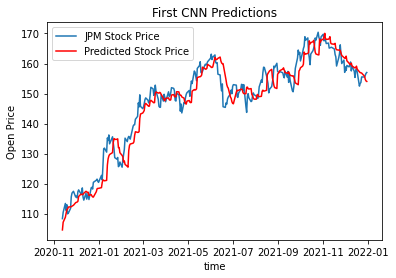

In [345]:
predicted_stock_price = model_RNN_4.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(58,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [338]:
# aggiungo un livello lstm in parallelo a quello già esistente; entrambi con funzione di attivazione tanh
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 2, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder1 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder2 =keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm2)
conc = keras.layers.concatenate([decoder1,decoder2])
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(conc)

model_RNN_5 = keras.Model(encoder_inputs, output)
model_RNN_5.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1d_134 (Conv1D)            (None, 9, 64)        192         ['input_100[0][0]']              
                                                                                                  
 conv1d_135 (Conv1D)            (None, 8, 64)        8256        ['conv1d_134[0][0]']             
                                                                                                  
 max_pooling1d_99 (MaxPooling1D  (None, 4, 64)       0           ['conv1d_135[0][0]']             
 )                                                                                         

In [339]:
batch_size = 16
epochs = 20
set_seed(456984)
model_RNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_RNN_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
19/19 [==============================] - 7s 20ms/step - loss: 0.2535 - MSE: 0.2535
Epoch 2/20
19/19 [==============================] - 0s 21ms/step - loss: 0.0423 - MSE: 0.0423
Epoch 3/20
19/19 [==============================] - 0s 22ms/step - loss: 0.0068 - MSE: 0.0068
Epoch 4/20
19/19 [==============================] - 0s 21ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 5/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - MSE: 0.0011
Epoch 6/20
19/19 [==============================] - 0s 18ms/step - loss: 6.3524e-04 - MSE: 6.3524e-04
Epoch 7/20
19/19 [==============================] - 0s 21ms/step - loss: 5.1649e-04 - MSE: 5.1649e-04
Epoch 8/20
19/19 [==============================] - 0s 19ms/step - loss: 4.3553e-04 - MSE: 4.3553e-04
Epoch 9/20
19/19 [==============================] - 0s 19ms/step - loss: 4.7602e-04 - MSE: 4.7602e-04
Epoch 10/20
19/19 [==============================] - 0s 18ms/step - loss: 4.8256e-04 - MSE: 4.8256e-04
Epoch 11/20
19/19 [

Mean Squared Error:	 16.98069459232396


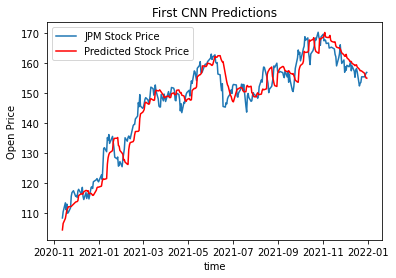

In [344]:
predicted_stock_price = model_RNN_5.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(58,5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:285])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()